In [1]:
import inspect
import matplotlib.pyplot as plt
import numpy as np
from L96_model import L96, L96s, L96_eq1_xdot, L96_2t_xdot_ydot, RK4
import time
import os

In [231]:
#WORKING

rng=np.random.default_rng()

config=dict(
    K=8, # Dimension of L96 "X" variables
    J=32, # Dimension of L96 "Y" variables
    obs_freq=10, # observation frequency (number of sampling intervals (si) per observation)
    F_truth=18, # F for truth signal
    F_fcst=18, # F for forecast (DA) model
    GCM_param=np.array([0,0,0,0]), # polynomial coefficicents for GCM parameterization
    ns_da=8000, # number of time samples for DA
    ns=8000, # number of time samples for truth signal
    ns_spinup=200, # number of time samples for spin up
    dt=0.005, # model timestep
    si=0.005, # truth sampling interval
    B_loc=4, # spatial localization radius for DA
    DA='EnKF', # DA method
    nens=400, # number of ensemble members for DA
    inflate_opt="relaxation", # method for DA model covariance inflation
    inflate_factor=0.68, # inflation factor
    hybrid_factor=0.1, # inflation factor for hybrid EnKF method
    param_DA=False, # switch to to parameter estimation with DA
    param_sd=[0.01,0.02,0.1,0.5], # polynomal parameter standard deviation
    param_inflate='multiplicative', # method for parameter variance inflation
    param_inf_factor=0.02, # parameter inflation factor
    obs_density=0.5, # fraction of spatial gridpoints where observations are collected
    DA_freq=10, # assimilation frequency (number of sampling intervals (si) per assimilation step)
    obs_sigma=.2, # observational error standard deviation
    save_fig=False, # switch to save figure file
    save_data=True, #  switch to save
)

# 0.68

In [289]:
rng=np.random.default_rng()

config=dict(
    K=8, # Dimension of L96 "X" variables
    J=32, # Dimension of L96 "Y" variables
    obs_freq=10, # observation frequency (number of sampling intervals (si) per observation)
    F_truth=18, # F for truth signal
    F_fcst=18, # F for forecast (DA) model
    GCM_param=np.array([0,0,0,0]), # polynomial coefficicents for GCM parameterization
    ns_da=8000, # number of time samples for DA
    ns=8000, # number of time samples for truth signal
    ns_spinup=200, # number of time samples for spin up
    dt=0.005, # model timestep
    si=0.005, # truth sampling interval
    B_loc=4, # spatial localization radius for DA
    DA='EnKF', # DA method
    nens=400, # number of ensemble members for DA
    inflate_opt="relaxation", # method for DA model covariance inflation
    inflate_factor=0.01, # inflation factor
    hybrid_factor=0.1, # inflation factor for hybrid EnKF method
    param_DA=False, # switch to to parameter estimation with DA
    param_sd=[0.01,0.02,0.1,0.5], # polynomal parameter standard deviation
    param_inflate='multiplicative', # method for parameter variance inflation
    param_inf_factor=0.02, # parameter inflation factor
    obs_density=0.5, # fraction of spatial gridpoints where observations are collected
    DA_freq=10, # assimilation frequency (number of sampling intervals (si) per assimilation step)
    obs_sigma=2., # observational error standard deviation
    save_fig=False, # switch to save figure file
    save_data=True, #  switch to save
)

# 0.68

In [290]:
def s(k,K):
    """A non-dimension coordinate from -1..+1 corresponding to k=0..K"""
    return 2 * ( 0.5 + k ) / K - 1

def get_dist(i,j,K):
    return abs(i-j) if abs(i-j)<=K/2 else K-abs(i-j)

def GCM(X0, F, dt, nt, param=[0]):
    time, hist, X = dt*np.arange(nt+1), np.zeros((nt+1,len(X0)))*np.nan, X0.copy()
    hist[0] = X
    
    for n in range(nt):
        X = X + dt * ( L96_eq1_xdot(X, F) - np.polyval(param, X) )

        hist[n+1], time[n+1] = X, dt*(n+1)
    return hist, time

# Generate observation operator, assuming linearity and model space observations
def ObsOp(K,l_obs,t_obs,i_t):
    nobs=l_obs.shape[-1]
    H=np.zeros((nobs,K))
    H[range(nobs),l_obs[t_obs==i_t]]=1
    return H

# localize covariance matrix based on the Gaspari-Cohn function
def cov_loc(B,loc=0):
    M,N = B.shape
    X,Y = np.ix_(np.arange(M),np.arange(N))
    dist=np.vectorize(get_dist)(X,Y,M)
    W=np.vectorize(gaspari_cohn)(dist,loc)
    return B*W,W

def gaspari_cohn(distance,radius):
    if distance==0:
        weight=1
    else: 
        if radius==0:
            weight=0
        else:
            ratio=distance/radius
            weight=0
            if ratio<=1:
                weight=-ratio**5/4+ratio**4/2+5*ratio**3/8-5*ratio**2/3+1
            elif ratio<=2:
                weight=ratio**5/12-ratio**4/2+5*ratio**3/8+5*ratio**2/3-5*ratio+4-2/3/ratio
    return weight

def find_obs(loc,obs,t_obs,l_obs,period):
    t_period=np.where((t_obs[:,0]>=period[0]) & (t_obs[:,0]<period[1]))
    obs_period=np.zeros(t_period[0].shape)
    obs_period[:]=np.nan
    for i in np.arange(len(obs_period)):
        if np.any(l_obs[t_period[0][i]]==loc):
            obs_period[i]=obs[t_period[0][i]][l_obs[t_period[0][i]]==loc]
    return obs_period

def running_ave(X,N):
    if N%2==0:
        N1,N2=-N/2,N/2
    else:
        N1,N2=-(N-1)/2,(N+1)/2
        
    X_sum=np.zeros(X.shape)
    for i in np.arange(N1,N2):
        X_sum=X_sum+np.roll(X,int(i),axis=0)
    return X_sum/N   

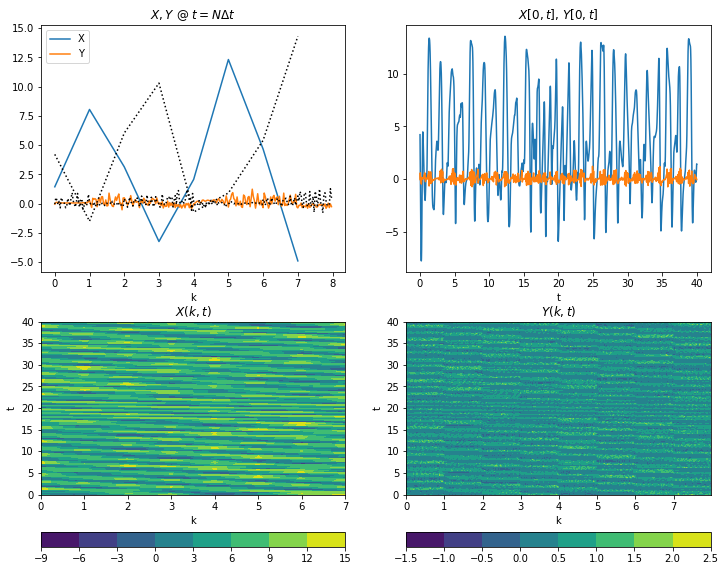

In [291]:
# Set up the "truth" 2-scale L96 model and generate initial conditions from a short spinup
M_truth = L96(config['K'], config['J'], F=config['F_truth'], dt=config['dt'])
M_truth.set_state(rng.standard_normal((config['K'])), 0*M_truth.j)
X_init,Y_init,_ = M_truth.run(config['si'], config['si']*config['ns_spinup'])
X_init, Y_init = X_init[-1,:],Y_init[-1,:]

# Run L96 to generate the "truth"
M_truth.set_state(X_init, Y_init)
X_truth,Y_truth,t_truth = M_truth.run(config['si'], config['si']*config['ns'])

# generate climatological background covariance for 2-scale L96 model
# B_clim = np.cov(X_truth.T)
# np.save('B_clim_L96.npy', B_clim)  

plt.figure(figsize=(12,10))
plt.subplot(221); # Snapshot of X[k]
plt.plot(M_truth.k, X_truth[-1,:], label='X');
plt.plot(M_truth.j/M_truth.J, Y_truth[-1,:], label='Y')
plt.legend(); plt.xlabel('k'); plt.title('$X,Y$ @ $t=N\Delta t$');
plt.plot(M_truth.k, X_truth[0,:], 'k:')
plt.plot(M_truth.j/M_truth.J, Y_truth[0,:], 'k:')
plt.subplot(222); # Sample time-series X[0](t), Y[0](t)
plt.plot(t_truth, X_truth[:,0], label='X');
plt.plot(t_truth, Y_truth[:,0], label='Y');
plt.xlabel('t'); plt.title('$X[0,t]$, $Y[0,t]$');
plt.subplot(223); # Full model history of X
plt.contourf(M_truth.k,t_truth,X_truth); plt.colorbar(orientation='horizontal'); plt.xlabel('k'); plt.ylabel('t'); plt.title('$X(k,t)$');
plt.subplot(224); # Full model history of Y
plt.contourf(M_truth.j/M_truth.J,t_truth,Y_truth); plt.colorbar(orientation='horizontal'); plt.xlabel('k'); plt.ylabel('t'); plt.title('$Y(k,t)$');

# # generate climatological background covariance for 1-scale L96 model
# M_1s = L96s(config['K'], F=config['F_truth'], dt=config['dt'], method=RK4)
# M_1s.set_state(X_init)
# X1_truth,t1_truth = M_1s.run(config['si']*config['ns'])
# B_clim_1s = np.cov(X1_truth.T)
# np.save('B_clim_1s.npy', B_clim_1s)  

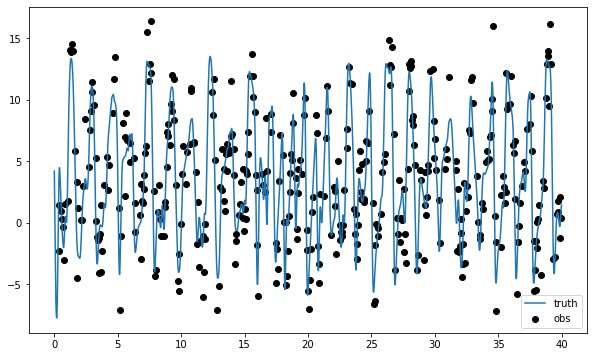

In [292]:
# Sample the "truth" to generate observations at certain times (t_obs) and locations (l_obs)
t_obs = np.tile(config['obs_freq']+np.arange(0,config['ns_da'],config['obs_freq']),
                [int(config['K']*config['obs_density']),1]
               ).T
l_obs = np.zeros(t_obs.shape,dtype='int')
for i in range(l_obs.shape[0]):
    l_obs[i,:] = rng.choice(config['K'], int(config['K']*config['obs_density']), replace=False)
X_obs = X_truth[t_obs,l_obs]+config['obs_sigma']*rng.standard_normal(l_obs.shape)

# Calculated observation covariance matrix, assuming independent observations
R = config['obs_sigma']**2*np.eye(int(config['K']*config['obs_density']))

plt.figure(figsize=[10,6])
plt.plot(t_truth[:],X_truth[:,0],label='truth')
plt.scatter(t_truth[t_obs[1:,0]],find_obs(0,X_obs,t_obs,l_obs,[t_obs[0,0],t_obs[-1,0]]),color='k',label='obs')
plt.legend();

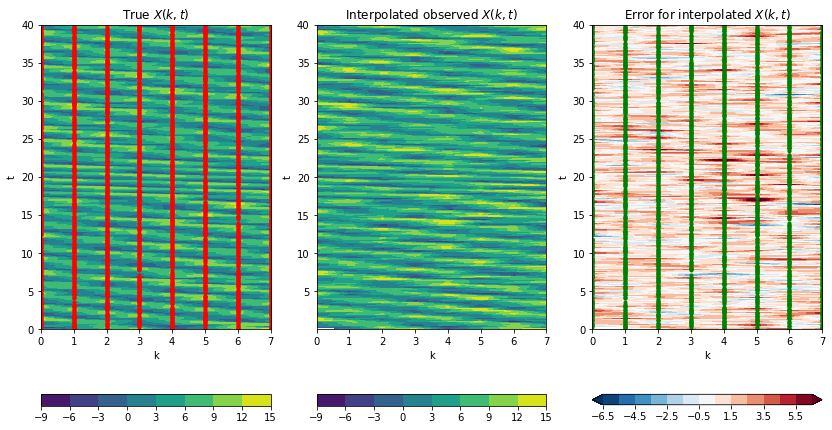

In [293]:
import matplotlib.tri

interpolator = matplotlib.tri.LinearTriInterpolator(
    matplotlib.tri.Triangulation(l_obs.flatten(), t_truth[t_obs.flatten()]),
    X_obs.flatten())
Xo = interpolator( *np.meshgrid(np.arange(config['K']), t_truth) )

plt.figure(figsize=[14,8])
plt.subplot(131);
plt.contourf(M_truth.k, t_truth, X_truth, levels=np.arange(-9,18,3));
plt.colorbar(orientation='horizontal'); plt.xlabel('k'); plt.ylabel('t'); plt.title('True $X(k,t)$');
plt.plot(l_obs, t_truth[t_obs], 'r.');
plt.subplot(132);
plt.tricontourf(l_obs.flatten(), t_truth[t_obs.flatten()], X_obs.flatten(), levels=np.arange(-9,18,3));
plt.colorbar(orientation='horizontal'); plt.xlabel('k'); plt.ylabel('t'); plt.title('Interpolated observed $X(k,t)$');
plt.subplot(133)
plt.contourf(M_truth.k, t_truth, Xo-X_truth, cmap=plt.cm.RdBu_r, levels=np.arange(-6.5,7,1), extend='both' );
plt.colorbar(orientation='horizontal'); plt.xlabel('k'); plt.ylabel('t'); plt.title('Error for interpolated $X(k,t)$');
plt.plot(l_obs, t_truth[t_obs], 'g.');

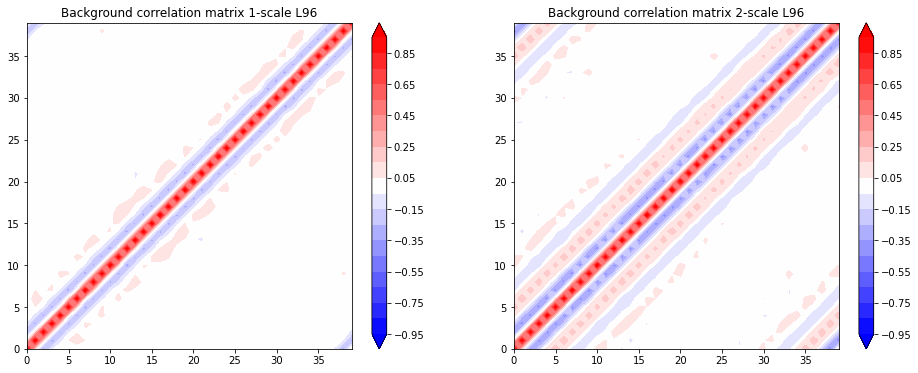

In [294]:
import DA_methods
import importlib
importlib.reload(DA_methods)

# load pre-calculated climatological background covariance matrix from a long simulation
B_clim1=np.load('B_clim_L96s.npy')
B_loc,W_clim=cov_loc(B_clim1,loc=config['B_loc'])

B_clim2=np.load('B_clim_L96.npy')
B_corr1=np.zeros(B_clim1.shape)
B_corr2=np.zeros(B_clim2.shape)
for i in range(B_clim1.shape[0]):
    for j in range(B_clim1.shape[1]):
        B_corr1[i,j]=B_clim1[i,j]/np.sqrt(B_clim1[i,i]*B_clim1[j,j])
        B_corr2[i,j]=B_clim2[i,j]/np.sqrt(B_clim2[i,i]*B_clim2[j,j])
        
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.contourf(B_corr1,cmap='bwr',extend='both',levels=np.linspace(-0.95,0.95,20))
plt.colorbar()
plt.title('Background correlation matrix 1-scale L96')
plt.subplot(122)
plt.contourf(B_corr2,cmap='bwr',extend='both',levels=np.linspace(-0.95,0.95,20))
plt.colorbar()
plt.title('Background correlation matrix 2-scale L96')
del B_corr2 # To make sure we don't accidentally use this

In [295]:
t0 = time.time()
# set up array to store DA increments
X_inc=np.zeros((int(config['ns_da']/config['DA_freq']),config['K'],config['nens']))
if config['DA']=='3DVar':
    X_inc=np.squeeze(X_inc)
t_DA=np.zeros(int(config['ns_da']/config['DA_freq']))

# initialize ensemble with perturbations
i_t=0
ensX=X_init[None,:,None]+rng.standard_normal((1,config['K'],config['nens']))*0.1
X_post=ensX[0,...]


if config['param_DA']:
    mean_param=np.zeros((int(config['ns_da']/config['DA_freq']),len(config['GCM_param'])))
    spread_param=np.zeros((int(config['ns_da']/config['DA_freq']),len(config['GCM_param'])))
    param_scale=config['param_sd']
    W=np.ones((config['K']+len(config['GCM_param']),config['K']+len(config['GCM_param'])))
    W[0:config['K'],0:config['K']]=W_clim
else: 
    W=W_clim
    param_scale=np.zeros(config['GCM_param'].shape)
    
ens_param=np.zeros((len(config['GCM_param']),config['nens']))
for i in range(len(config['GCM_param'])):
    ens_param[i,:]=config['GCM_param'][i]+rng.normal(scale=param_scale[i],size=config['nens'])
    
# DA cycles
for cycle in np.arange(0,config['ns_da']/config['DA_freq'],dtype='int'):
# for cycle in np.arange(0,1,dtype='int'):
    
    # set up array to store model forecast for each DA cycle
    ensX_fcst=np.zeros((config['DA_freq']+1,config['K'],config['nens']))

    # model forecast for next DA cycle
    for n in range(config['nens']):
        ensX_fcst[...,n] = GCM(X_post[0:config['K'],n], config['F_fcst'], config['dt'], config['DA_freq'], ens_param[:,n])[0]
    i_t=i_t+config['DA_freq']

    # get prior/background from the forecast
    X_prior=ensX_fcst[-1,...]  # get prior from model integration
    
    # call DA
    t_DA[cycle]=t_truth[i_t]
    if config['DA']=='EnKF':
        H=ObsOp(config['K'],l_obs,t_obs,i_t)
        # augment state vector with parameters when doing parameter estimation
        if config['param_DA']:
            H=np.concatenate((H,np.zeros((H.shape[0],len(config['GCM_param'])))),axis=-1)
            X_prior=np.concatenate((X_prior,ens_param))
        B_ens = np.cov(X_prior)
        B_ens_loc = B_ens*W[0:config['K'],0:config['K']]
        X_post=DA_methods.EnKF(X_prior,X_obs[t_obs==i_t],H,R,B_ens_loc)
        X_post[0:config['K'],:]=DA_methods.ens_inflate(X_post[0:config['K'],:],X_prior[0:config['K'],:],
                                                       config['inflate_opt'],config['inflate_factor'])
        X_post[-len(config['GCM_param']):None,:]=DA_methods.ens_inflate(X_post[-len(config['GCM_param']):None,:],
                                                                        X_prior[-len(config['GCM_param']):None,:],
                                                                        config['param_inflate'],
                                                                        config['param_inf_factor'])        
        if config['param_DA']:
            ens_param=X_post[-len(config['GCM_param']):None,:]
    elif config['DA']=='HyEnKF':
        H=ObsOp(config['K'],l_obs,t_obs,i_t)
        B_ens = np.cov(X_prior)*(1-config['hybrid_factor'])+B_clim1*config['hybrid_factor']
        B_ens_loc = B_ens*W
        X_post=DA_methods.EnKF(X_prior,X_obs[t_obs==i_t],H,R,B_ens_loc)
        X_post=DA_methods.ens_inflate(X_post,X_prior,config['inflate_opt'],config['inflate_factor'])
    elif config['DA']=='3DVar':
        X_prior=np.squeeze(X_prior)
        H=ObsOp(config['K'],l_obs,t_obs,i_t)
        X_post=DA_methods.Lin3dvar(X_prior,X_obs[t_obs==i_t],H,R,B_loc,3)
        X_post=X_post[:,None]
    elif config['DA']=='Replace':
        X_post=X_prior
        X_post[l_obs[t_obs==i_t]]=X_obs[t_obs==i_t]
    elif config['DA']=='None':
        X_post=X_prior
        
    if not config['DA']=='None':
        X_inc[cycle,...]=np.squeeze(X_post[0:config['K'],...])-X_prior[0:config['K'],...]  # get current increments
        # get posterior info about the estimated parameters
        if config['param_DA']:
            mean_param[cycle,:]=ens_param.mean(axis=-1)
            spread_param[cycle,:]=ens_param.std(axis=-1)
            
    # reset initial conditions for next DA cycle
    ensX_fcst[-1,:,:]=X_post[0:config['K'],:]
    ensX=np.concatenate((ensX,ensX_fcst[1:None,...]))
    
if config['DA']=='3DVar':
    X_inc=X_inc[...,None]

print(X_inc.shape)
t1 = time.time()
print(t1-t0)

(800, 8, 400)
84.51333856582642


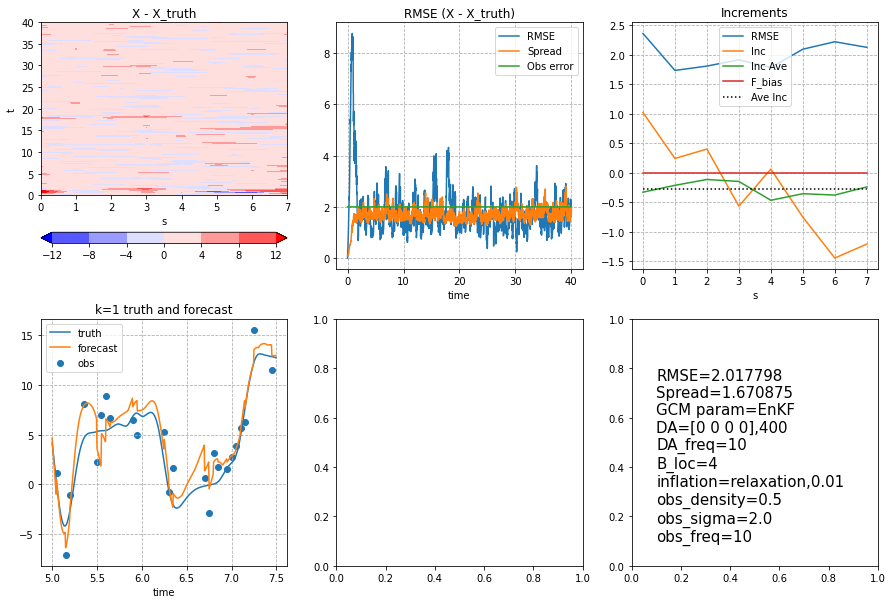

In [296]:
# post processing and visualization
meanX=np.mean(ensX,axis=-1)
clim=np.max(np.abs(meanX-X_truth[0:(config['ns_da']+1),:]))

fig, axes=plt.subplots(2,3,figsize=(15,10))
ch=axes[0,0].contourf(M_truth.k,t_truth[0:(config['ns_da']+1)],meanX-X_truth[0:(config['ns_da']+1),:],
                           cmap='bwr' ,vmin=-clim, vmax=clim, extend='both');
plt.colorbar(ch,ax=axes[0,0],orientation='horizontal'); 
axes[0,0].set_xlabel('s'); axes[0,0].set_ylabel('t'); axes[0,0].set_title('X - X_truth');
axes[0,1].plot(t_truth[0:(config['ns_da']+1)], np.sqrt(((meanX-X_truth[0:(config['ns_da']+1),:])**2).mean(axis=-1)),label='RMSE'); 
axes[0,1].plot(t_truth[0:(config['ns_da']+1)], np.mean(np.std(ensX,axis=-1),axis=-1),label='Spread'); 
axes[0,1].plot(t_truth[0:(config['ns_da']+1)], config['obs_sigma']*np.ones((config['ns_da']+1)),label='Obs error');
axes[0,1].legend()
axes[0,1].set_xlabel('time'); axes[0,1].set_title('RMSE (X - X_truth)');
axes[0,1].grid(which='both',linestyle='--')

axes[0,2].plot(M_truth.k, np.sqrt(((meanX-X_truth[0:(config['ns_da']+1),:])**2).mean(axis=0)),label='RMSE'); 
X_inc_ave=X_inc/config['DA_freq']/config['si']
axes[0,2].plot(M_truth.k, X_inc_ave.mean(axis=(0,-1)),label='Inc'); 
axes[0,2].plot(M_truth.k, running_ave(X_inc_ave.mean(axis=(0,-1)),7),label='Inc Ave'); 
axes[0,2].plot(M_truth.k, np.ones(M_truth.k.shape)*(config['F_fcst']-config['F_truth']),label='F_bias'); 
axes[0,2].plot(M_truth.k, np.ones(M_truth.k.shape)*(X_inc/config['DA_freq']/config['si']).mean(),'k:',label='Ave Inc'); 
axes[0,2].legend()
axes[0,2].set_xlabel('s'); axes[0,2].set_title('Increments');
axes[0,2].grid(which='both',linestyle='--')

# X_inc_ave=(X_inc/config['DA_freq']/config['si']).mean(axis=(1,2)).\
#         reshape(int(config['ns_da']/ann_period),int(ann_period/config['DA_freq'])).mean(axis=0)
# axes[0,2].plot(np.arange(ann_period/config['DA_freq']),X_inc_ave,label='Inc')
# axes[0,2].plot(np.arange(ann_period/config['DA_freq']),running_ave(X_inc_ave,10),label='Inc Ave');
# axes[0,2].plot(np.arange(0,ann_period/config['DA_freq'],mon_period/config['DA_freq']),
#                -2*np.sin(2*np.pi*np.arange(mon_per_ann)/mon_per_ann),label='F_bias')
# axes[0,2].legend()
# axes[0,2].set_xlabel('"annual cycle"'); axes[0,2].set_title('Increments');
# axes[0,2].grid(which='both',linestyle='--')

plot_start,plot_end=1000, 1500
plot_start_DA, plot_end_DA=int(plot_start/config['DA_freq']), int(plot_end/config['DA_freq'])
plot_x=0
axes[1,0].plot(t_truth[plot_start:plot_end],X_truth[plot_start:plot_end,plot_x],label='truth')
axes[1,0].plot(t_truth[plot_start:plot_end],meanX[plot_start:plot_end,plot_x],label='forecast')
axes[1,0].scatter(t_DA[plot_start_DA-1:plot_end_DA-1],find_obs(plot_x,X_obs,t_obs,l_obs,[plot_start,plot_end]),label='obs')
axes[1,0].grid(which='both',linestyle='--')
axes[1,0].set_xlabel('time'); axes[1,0].set_title('k='+str(plot_x+1)+' truth and forecast');
axes[1,0].legend()

if config['param_DA']:
    for i,c in zip(np.arange(len(config['GCM_param']),0,-1),['r','b','g','k']):
        axes[1,1].plot(t_DA,running_ave(mean_param[:,i-1],100),c+'-',
                       label='C{} {:3f}'.format(i-1,mean_param[int(len(t_DA)/2):None,i-1].mean()))
        axes[1,1].plot(t_DA,running_ave(mean_param[:,i-1]+spread_param[:,i-1],100),c+':',
                       label='SD {:3f}'.format(spread_param[int(len(t_DA)/2):None,i-1].mean()))
        axes[1,1].plot(t_DA,running_ave(mean_param[:,i-1]-spread_param[:,i-1],100),c+':')
    axes[1,1].legend()
    axes[1,1].grid(which='both',linestyle='--')

axes[1,2].text(0.1,0.1,'RMSE={:3f}\nSpread={:3f}\nGCM param={}\nDA={},{}\nDA_freq={}\nB_loc={}\ninflation={},{}\nobs_density={}\nobs_sigma={}\nobs_freq={}'.\
               format(np.sqrt(((meanX-X_truth[0:(config['ns_da']+1),:])**2).mean()),
                      np.mean(np.std(ensX,axis=-1)),config['DA'],config['GCM_param'],
                      config['nens'],config['DA_freq'],config['B_loc'],
                      config['inflate_opt'],config['inflate_factor'],config['obs_density'],config['obs_sigma'],
                      config['obs_freq']),
               fontsize=15)

if config['save_fig']:
    data_path="./DA_data/"
    if not os.path.isdir(data_path):
        os.mkdir(data_path)
    exp_number=np.random.randint(1,10000)
    f = open(data_path+'config_{0}.txt'.format(exp_number),"w")
    f.write( data_path+str(config) )
    f.close()
    plt.savefig(data_path+'fig_{0}.png'.format(exp_number))

(1.8878074217402827, 2.0177983562212494)

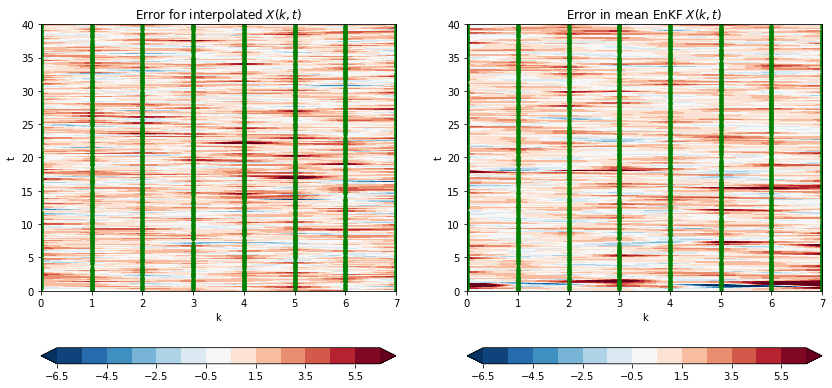

In [297]:
plt.figure(figsize=[14,7])
plt.subplot(121);
plt.contourf(M_truth.k, t_truth, Xo-X_truth, cmap=plt.cm.RdBu_r, levels=np.arange(-6.5,7,1), extend='both' );
plt.colorbar(orientation='horizontal'); plt.xlabel('k'); plt.ylabel('t'); plt.title('Error for interpolated $X(k,t)$');
plt.plot(l_obs, t_truth[t_obs], 'g.');
plt.subplot(122);
plt.contourf(M_truth.k, t_truth, meanX - X_truth, cmap=plt.cm.RdBu_r, levels=np.arange(-6.5,7,1), extend='both');
plt.colorbar(orientation='horizontal'); plt.xlabel('k'); plt.ylabel('t'); plt.title('Error in mean EnKF $X(k,t)$');
plt.plot(l_obs, t_truth[t_obs], 'g.');
np.sqrt(((Xo-X_truth)**2).mean()), np.sqrt(((meanX-X_truth)**2).mean()), 

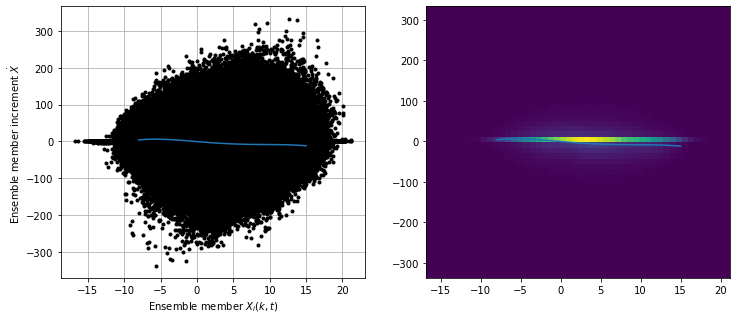

In [298]:
jj = np.abs(X_inc_ave[0:,:].flatten())>-0.1
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot( ensX[t_obs[0:,0],:].flatten()[jj], X_inc_ave[0:,:].flatten()[jj], 'k.' );
plt.grid()
x = np.linspace(-8,15,100)
p18 = [0.000707, -0.0130, -0.0190, 1.59, 0.275] # Polynomial from Wilks, 2005
plt.plot(x, -np.polyval(p18, x), label='$P_4(X_k)$ - Wilks, 2005');
# plt.plot( ensX[t_obs[0:,0],l_obs,:].flatten(), X_inc_ave[0:,l_obs].flatten(), 'k.' );
plt.xlabel('Ensemble member $X_i(k,t)$'); plt.ylabel('Ensemble member increment $\dot{X}$');
ensX.shape, t_obs.shape, X_inc_ave.shape, l_obs.shape, X_inc_ave[0:,l_obs].shape, #ensX[t_obs[0:,0],l_obs,:]
plt.subplot(122)
plt.hist2d( ensX[t_obs[0:,0],:].flatten()[jj], X_inc_ave[0:,:].flatten()[jj], bins=50 );
plt.plot(x, -np.polyval(p18, x), label='$P_4(X_k)$ - Wilks, 2005');

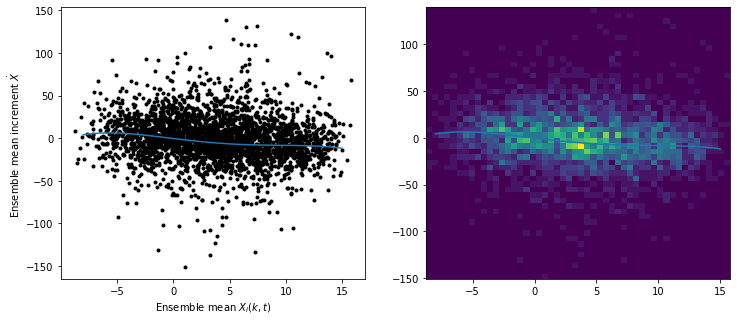

In [299]:
jj = np.abs(X_inc_ave.mean(axis=-1).flatten())>0.1
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot( meanX[t_obs[0:,0]].flatten()[jj], X_inc_ave.mean(axis=-1).flatten()[jj], 'k.')
plt.plot(x, -np.polyval(p18, x), label='$P_4(X_k)$ - Wilks, 2005');
plt.xlabel('Ensemble mean $X_i(k,t)$'); plt.ylabel('Ensemble mean increment $\dot{X}$');
plt.subplot(122)
plt.hist2d( meanX[t_obs[0:,0]].flatten()[jj], X_inc_ave.mean(axis=-1)[0:,:].flatten()[jj], bins=50 );
plt.plot(x, -np.polyval(p18, x), label='$P_4(X_k)$ - Wilks, 2005');

In [300]:
X_inc_ave.shape

(800, 8, 400)

(38.0, 40.0)

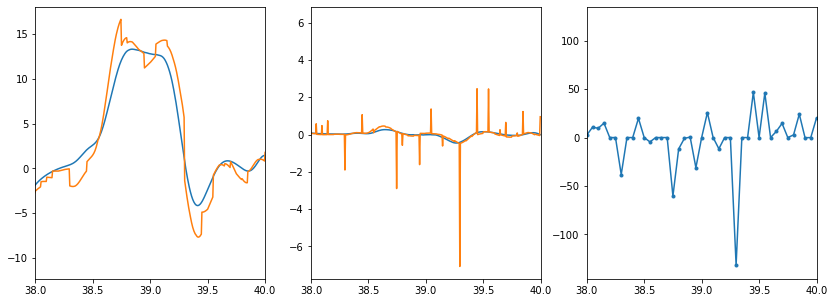

In [301]:
plt.figure(figsize=(14,5))
plt.subplot(131)
plt.plot(t_truth, X_truth[:,0] );
plt.plot(t_truth, meanX[:,0] );
plt.xlim(38,40)
plt.subplot(132)
plt.plot(t_truth[:-1], np.diff(X_truth[:,0]) );
plt.plot(t_truth[:-1], np.diff(meanX[:,0]) );
plt.xlim(38,40)
plt.subplot(133)
plt.plot(t_truth[t_obs[:,0]], X_inc_ave[:,0].mean(axis=-1), '.-' );
plt.xlim(38,40)

In [ ]:
#save DA output for further analysis
if config['save_data']:
    config_str='K_'+str(config['K'])+'_J_'+str(config['J'])+'_obs_freq_'+str(config['obs_freq'])\
                +'_F_truth_'+str(config['F_truth'])+'_F_fcst_'+str(config['F_fcst'])+'_ns_da_'\
                +str(config['ns_da'])+'_ns_'+str(config['ns'])+'_ns_spinup_'+str(config['ns_spinup'])\
                +'_dt_'+str(config['dt'])+'_si_'+str(config['si'])+'_B_loc_'+str(config['B_loc'])\
                +'_DA_'+str(config['DA'])+'_nens_'+str(config['nens'])\
                +'_inflate_opt_'+str(config['inflate_opt'])+'_inflate_factor_'+str(config['inflate_factor'])\
                +'_hybrid_factor_'+str(config['hybrid_factor'])+'_obs_density_'+str(config['obs_density'])\
                +'_DA_freq_'+str(config['DA_freq'])+'_obs_sigma_'+str(config['obs_sigma'])+'.npz'

    data_path="./DA_data/"
    if not os.path.isdir(data_path):
        os.mkdir(data_path)

    #np.savez(data_path+config_str,meanX=meanX,ensX=ensX,X_truth=X_truth,X_inc=X_inc,X_inc_ave=X_inc_ave)
#     np.savez(data_path+config_str,meanX=meanX,X_truth=X_truth,X_inc_ave=X_inc_ave)

In [ ]:
plt.figure(figsize=[13,5])
plt.subplot(131);
plt.contourf(M_truth.k, t_truth[:-1], np.diff(X_truth,axis=0)/config['si'],
             cmap=plt.cm.RdBu_r, levels=np.arange(-65,70,10), extend='both' );
plt.colorbar(orientation='horizontal'); plt.xlabel('k'); plt.ylabel('t'); plt.title('True $\partial_t X(k,t)$');
plt.subplot(132);
plt.contourf(M_truth.k, t_truth[:-1], np.diff(meanX,axis=0)/config['si'],
             cmap=plt.cm.RdBu_r, levels=np.arange(-65,70,10), extend='both' );
plt.colorbar(orientation='horizontal'); plt.xlabel('k'); plt.ylabel('t'); plt.title('EnKF $\partial_t X(k,t)$');
# plt.plot(l_obs, t_truth[t_obs], 'g.');
plt.subplot(133);
plt.contourf(M_truth.k, t_truth[:-1], np.diff(Xo,axis=0)/config['si'],
             cmap=plt.cm.RdBu_r, levels=np.arange(-65,70,10), extend='both' );
plt.colorbar(orientation='horizontal'); plt.xlabel('k'); plt.ylabel('t'); plt.title('Interpolated obs $\partial_t X(k,t)$');

In [ ]:
plt.figure(figsize=[13,5])
plt.subplot(131);
plt.contourf(M_truth.k, t_truth[:-1], np.diff(X_truth,axis=0)/config['si']-L96_eq1_xdot( X_truth[:-1].T, config['F_fcst']).T,
             cmap=plt.cm.RdBu_r, levels=np.arange(-65,70,10), extend='both' );
plt.colorbar(orientation='horizontal'); plt.xlabel('k'); plt.ylabel('t'); plt.title('True $\partial_t X(k,t) - \dot{X}$');
plt.subplot(132);
plt.contourf(M_truth.k, t_truth[:-1], np.diff(meanX,axis=0)/config['si']-L96_eq1_xdot( meanX[:-1].T, config['F_fcst']).T,
             cmap=plt.cm.RdBu_r, levels=np.arange(-65,70,10), extend='both' );
plt.colorbar(orientation='horizontal'); plt.xlabel('k'); plt.ylabel('t'); plt.title('EnKF $\partial_t X(k,t) - \dot{X}$');
plt.subplot(133);
plt.contourf(M_truth.k, t_truth[:-1], np.diff(Xo,axis=0)/config['si']-L96_eq1_xdot( Xo[:-1].T, config['F_fcst']).T,
             cmap=plt.cm.RdBu_r, levels=np.arange(-65,70,10), extend='both' );
plt.colorbar(orientation='horizontal'); plt.xlabel('k'); plt.ylabel('t'); plt.title('Interpolated obs $\partial_t X(k,t) - \dot{X}$');

In [ ]:
plt.figure(figsize=[13,5])
plt.subplot(131);
plt.hist2d(X_truth[:-1].flatten(),
           (np.diff(X_truth,axis=0)/config['si']-L96_eq1_xdot( X_truth[:-1].T, config['F_fcst']).T).flatten(),
          bins=50)
# plt.colorbar(orientation='horizontal'); plt.xlabel('k'); plt.ylabel('t'); plt.title('True $\partial_t X(k,t)$');
plt.subplot(132);
plt.hist2d(X_truth[:-1].flatten(),
           (np.diff(X_truth,axis=0)/config['si']-L96_eq1_xdot( X_truth[:-1].T, config['F_fcst']).T).flatten(),
          bins=50)
# plt.contourf(M_truth.k, t_truth[:-1], np.diff(meanX,axis=0)/config['si']-L96_eq1_xdot( meanX[:-1].T, config['F_fcst']).T,
#              cmap=plt.cm.RdBu_r, levels=np.arange(-65,70,10), extend='both' );
# plt.colorbar(orientation='horizontal'); plt.xlabel('k'); plt.ylabel('t'); plt.title('EnKF $\partial_t X(k,t)$');
plt.subplot(133);
plt.contourf(M_truth.k, t_truth[:-1], np.diff(Xo,axis=0)/config['si']-L96_eq1_xdot( Xo[:-1].T, config['F_fcst']).T,
             cmap=plt.cm.RdBu_r, levels=np.arange(-65,70,10), extend='both' );
plt.colorbar(orientation='horizontal'); plt.xlabel('k'); plt.ylabel('t'); plt.title('Interpolated obs $\partial_t X(k,t)$');

In [ ]:
corrected_Xdot = np.diff(meanX, axis=0) / config['dt']
uncorrected_Xdot = L96_eq1_xdot( meanX[:-1].T, config['F_fcst']).T

In [ ]:
plt.plot( meanX[:-1].flatten(), (1*corrected_Xdot+0*uncorrected_Xdot).flatten(), 'k.' )
plt.ylim(-50,50)